   InvoiceNo StockCode                          Description  Quantity  \
0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1     536365     71053                  WHITE METAL LANTERN         6   
2     536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2010-12-01 08:26:00       2.55       17850  United Kingdom  
1  2010-12-01 08:26:00       3.39       17850  United Kingdom  
2  2010-12-01 08:26:00       2.75       17850  United Kingdom  
3  2010-12-01 08:26:00       3.39       17850  United Kingdom  
4  2010-12-01 08:26:00       3.39       17850  United Kingdom  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392692 entries, 0 to 392691
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       ------

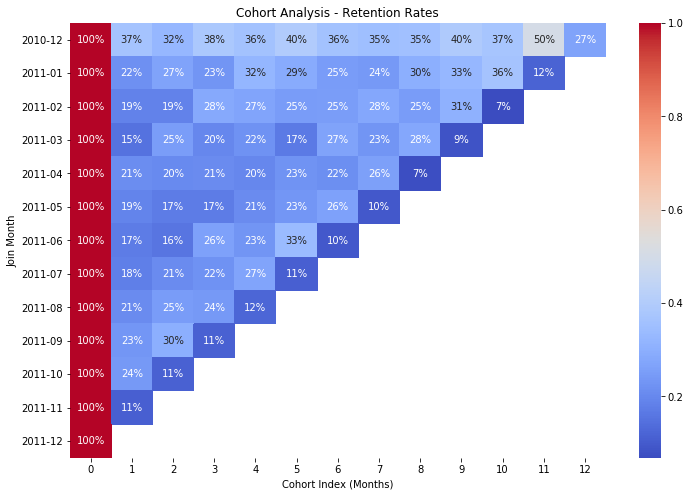

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드
data = pd.read_csv('C:/2024_2/online_retail_preprocessed.csv')

# 2. 데이터 구조 확인
print(data.head())
print(data.info())

# 3. 날짜 데이터를 DateTime 형식으로 변환
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# 4. 코호트 기준 설정 (예: 첫 구매 월)
data['CohortMonth'] = data['InvoiceDate'].dt.to_period('M')
data['JoinMonth'] = data.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# 5. 코호트 연령 계산 (월 차이)
data['CohortIndex'] = (data['CohortMonth'] - data['JoinMonth']).apply(lambda x: x.n)

# 6. 코호트 분석 테이블 생성
cohort_data = data.groupby(['JoinMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index='JoinMonth', columns='CohortIndex', values='CustomerID')

# 7. 코호트별 비율 계산
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

# 8. 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(retention_matrix, annot=True, fmt='.0%', cmap='coolwarm')
plt.title('Cohort Analysis - Retention Rates')
plt.xlabel('Cohort Index (Months)')
plt.ylabel('Join Month')
plt.show()


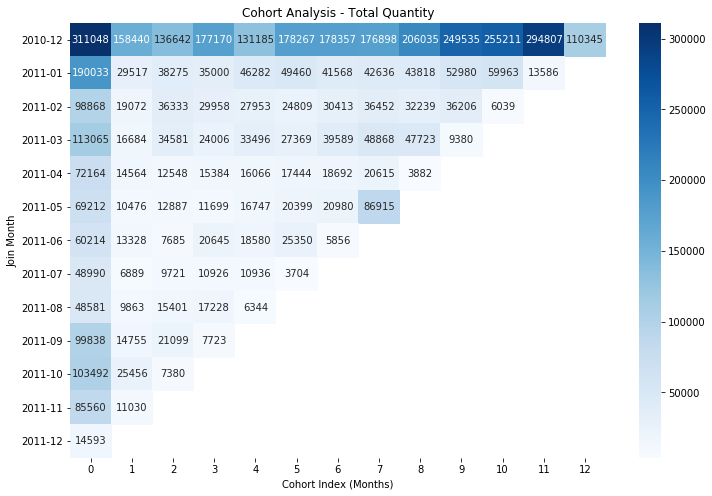

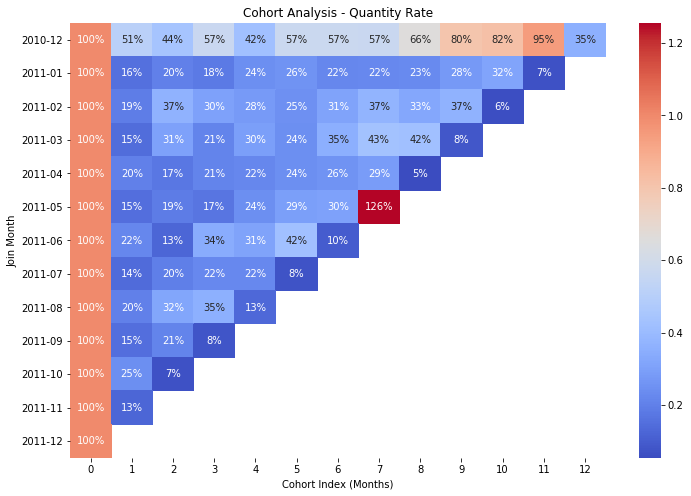

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 로드
data = pd.read_csv('C:/2024_2/online_retail_preprocessed.csv')

# 2. 데이터 구조 확인
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

# 3. 코호트 기준 설정 (예: 첫 구매 월)
data['CohortMonth'] = data['InvoiceDate'].dt.to_period('M')
data['JoinMonth'] = data.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

# 4. 코호트 연령 계산 (월 차이)
data['CohortIndex'] = (data['CohortMonth'] - data['JoinMonth']).apply(lambda x: x.n)

# 5. 코호트별 `Quantity` 합계 계산
cohort_quantity = data.groupby(['JoinMonth', 'CohortIndex'])['Quantity'].sum().reset_index()
quantity_pivot = cohort_quantity.pivot(index='JoinMonth', columns='CohortIndex', values='Quantity')

# 6. 코호트별 비율 계산 (평균 또는 비율)
# Optional: 코호트별 총 Quantity 대비 비율 계산
cohort_size = quantity_pivot.iloc[:, 0]
quantity_rate_matrix = quantity_pivot.divide(cohort_size, axis=0)

# 7. 시각화 (총 구매량 기준)
plt.figure(figsize=(12, 8))
sns.heatmap(quantity_pivot, annot=True, fmt='.0f', cmap='Blues')
plt.title('Cohort Analysis - Total Quantity')
plt.xlabel('Cohort Index (Months)')
plt.ylabel('Join Month')
plt.show()

# 8. 시각화 (비율 기준)
plt.figure(figsize=(12, 8))
sns.heatmap(quantity_rate_matrix, annot=True, fmt='.0%', cmap='coolwarm')
plt.title('Cohort Analysis - Quantity Rate')
plt.xlabel('Cohort Index (Months)')
plt.ylabel('Join Month')
plt.show()


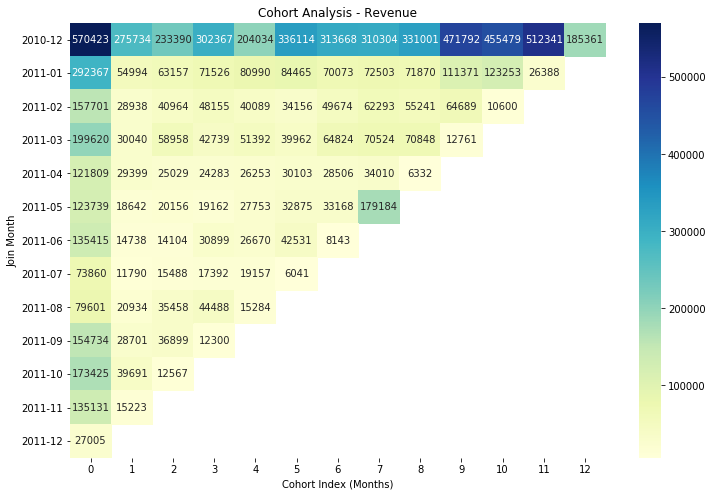

In [4]:
# 1. 코호트별 매출 합계 계산
data['Revenue'] = data['Quantity'] * data['UnitPrice']
cohort_revenue = data.groupby(['JoinMonth', 'CohortIndex'])['Revenue'].sum().reset_index()
revenue_pivot = cohort_revenue.pivot(index='JoinMonth', columns='CohortIndex', values='Revenue')

# 2. 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(revenue_pivot, annot=True, fmt='.0f', cmap='YlGnBu')
plt.title('Cohort Analysis - Revenue')
plt.xlabel('Cohort Index (Months)')
plt.ylabel('Join Month')
plt.show()


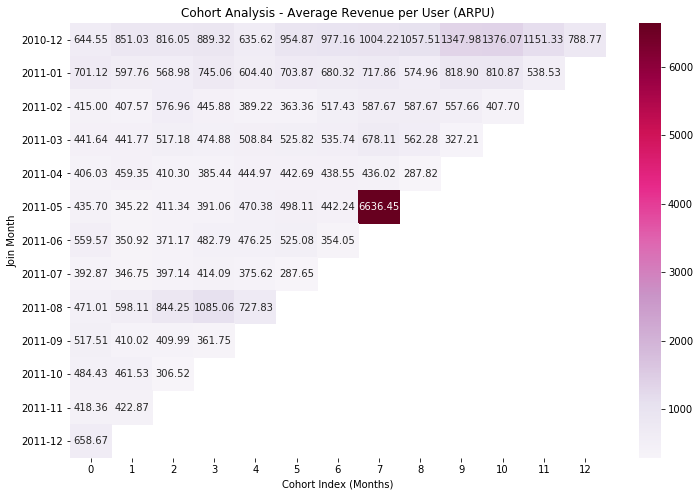

In [10]:
# 1. 코호트별 고객 수와 매출 합계 계산
cohort_customers = data.groupby(['JoinMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_customers.rename(columns={'CustomerID': 'CustomerCount'}, inplace=True)
cohort_revenue = data.groupby(['JoinMonth', 'CohortIndex'])['Revenue'].sum().reset_index()

# 2. ARPU 계산
cohort_avg_revenue = pd.merge(cohort_revenue, cohort_customers, on=['JoinMonth', 'CohortIndex'])
cohort_avg_revenue['ARPU'] = cohort_avg_revenue['Revenue'] / cohort_avg_revenue['CustomerCount']
arpu_pivot = cohort_avg_revenue.pivot(index='JoinMonth', columns='CohortIndex', values='ARPU')

# 3. 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(arpu_pivot, annot=True, fmt='.2f', cmap='PuRd')
plt.title('Cohort Analysis - Average Revenue per User (ARPU)')
plt.xlabel('Cohort Index (Months)')
plt.ylabel('Join Month')
plt.show()


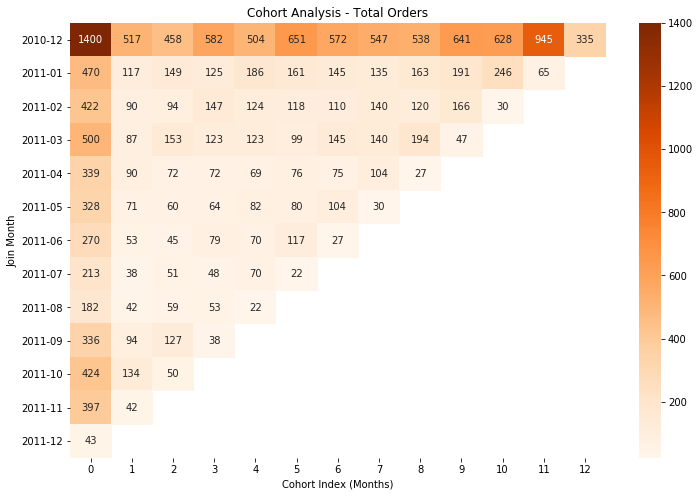

In [5]:
# 1. 코호트별 주문 수 계산
cohort_orders = data.groupby(['JoinMonth', 'CohortIndex'])['InvoiceNo'].nunique().reset_index()
order_pivot = cohort_orders.pivot(index='JoinMonth', columns='CohortIndex', values='InvoiceNo')

# 2. 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(order_pivot, annot=True, fmt='.0f', cmap='Oranges')
plt.title('Cohort Analysis - Total Orders')
plt.xlabel('Cohort Index (Months)')
plt.ylabel('Join Month')
plt.show()


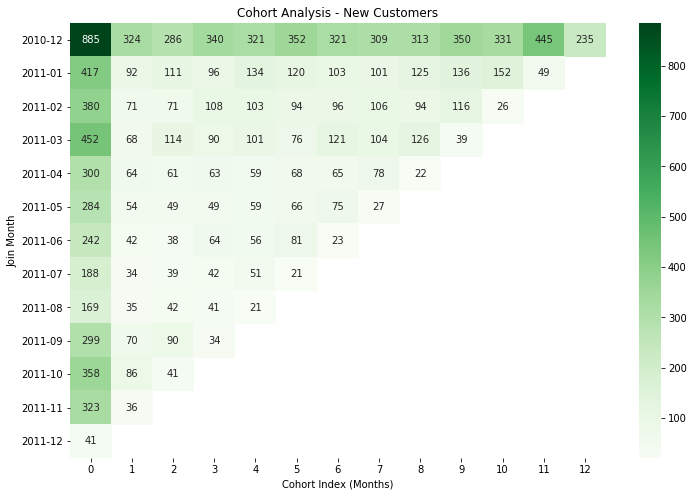

In [8]:
# 1. 고객 수 집계 (cohort_customers 정의)
cohort_customers = data.groupby(['JoinMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_customers.rename(columns={'CustomerID': 'CustomerCount'}, inplace=True)

# 2. 신규 고객 수 분석 (피벗 테이블 생성)
new_customers = cohort_customers.pivot(index='JoinMonth', columns='CohortIndex', values='CustomerCount')

# 3. 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(new_customers, annot=True, fmt='.0f', cmap='Greens')
plt.title('Cohort Analysis - New Customers')
plt.xlabel('Cohort Index (Months)')
plt.ylabel('Join Month')
plt.show()


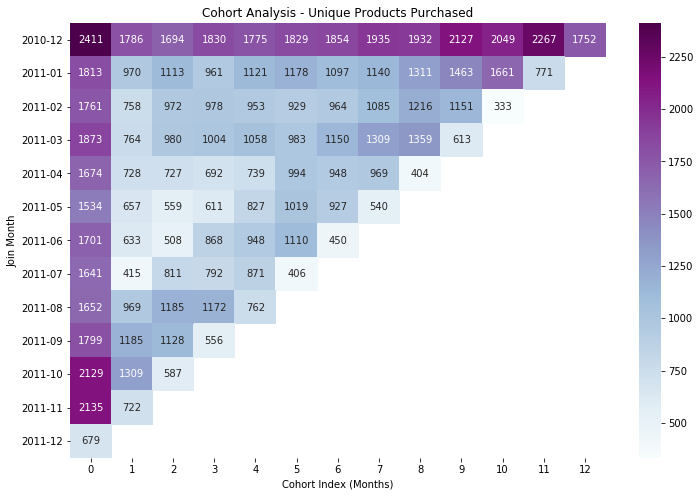

In [7]:
# 1. 코호트별 고유 상품 수 계산
cohort_unique_products = data.groupby(['JoinMonth', 'CohortIndex'])['StockCode'].nunique().reset_index()
unique_products_pivot = cohort_unique_products.pivot(index='JoinMonth', columns='CohortIndex', values='StockCode')

# 2. 시각화
plt.figure(figsize=(12, 8))
sns.heatmap(unique_products_pivot, annot=True, fmt='.0f', cmap='BuPu')
plt.title('Cohort Analysis - Unique Products Purchased')
plt.xlabel('Cohort Index (Months)')
plt.ylabel('Join Month')
plt.show()
